# Active Learning

## Imports

In [8]:
import numpy as np           
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import layers
from keras.layers import Input, Conv1D, Dropout, Flatten, Dense, MaxPooling1D
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from modAL.models import ActiveLearner
import matplotlib as mpl
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## Data Preprocessing(480)

In [40]:
# Constants
#FILE_PATHS = [r'New data\test_data.csv', r'New data\test_label.csv', r'New data/train_data.csv', r'New data/train_label.csv']
FILE_PATHS = [r'test_data.csv', r'test_label.csv', r'train_data.csv', r'train_label.csv']
#FILE_PATHS = [r'New data/test_data.csv', r'New data/test_label.csv', r'train_data.csv', r'train_label.csv']
x_train = pd.read_csv(FILE_PATHS[2], header=None)
y_train = pd.read_csv(FILE_PATHS[3], header=None)
x_test = pd.read_csv(FILE_PATHS[0], header=None)
y_test = pd.read_csv(FILE_PATHS[1], header=None)
n = 480
idx = np.random.choice(range(len(x_train)),
                               size=n,
                               replace=False)
x_train = x_train.iloc[idx]
y_train = y_train.iloc[idx]
x_train = x_train.to_numpy()

y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_test = keras.utils.to_categorical(y_test, num_classes=3)
x_train,y_train = shuffle(x_train,y_train,random_state=42)
x_test,y_test = shuffle(x_test,y_test,random_state=42)


In [ ]:
#print unique labels in y_train and count them

print(x_train.shape)
y_train1 = y_train.argmax(axis=1)
print(np.unique(y_train1, return_counts=True))

## Data Preprocessing

In [199]:
# Constants
#FILE_PATHS = [r'New data\test_data.csv', r'New data\test_label.csv', r'New data/train_data.csv', r'New data/train_label.csv']
FILE_PATHS = [r'test_data.csv', r'test_label.csv', r'train_data.csv', r'train_label.csv']
x_train = pd.read_csv(FILE_PATHS[2], header=None)
y_train = pd.read_csv(FILE_PATHS[3], header=None)
x_test = pd.read_csv(FILE_PATHS[0], header=None)
y_test = pd.read_csv(FILE_PATHS[1], header=None)
performance = pd.read_csv('performance.csv', header=None).to_numpy()
y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_test = keras.utils.to_categorical(y_test, num_classes=3)
x_train, y_train = shuffle(x_train, y_train, random_state=45)
#x_test, y_test = shuffle(x_test, y_test, random_state=5)

# assemble initial data
n_initial = 40
initial_idx = np.random.choice(range(len(x_train)),
                               size=n_initial,
                               replace=False)
x_initial = x_train.iloc[initial_idx]
y_initial = y_train[initial_idx]
x_initial = x_initial.to_numpy()

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)




In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

os.environ['LOKY_MAX_CPU_COUNT'] = '4'  

# Load dataset
data_path = r"train_data.csv"
labels_path = r"train_label.csv"

# Read the original dataset from the file each time (prevents accumulating noise)
data_original = pd.read_csv(data_path, header=None)
labels_true = pd.read_csv(labels_path, header=None).to_numpy().flatten()

# Make a copy of the original data to work on
noisy_data = data_original.copy()

# Standardize the data before adding noise
scaler = StandardScaler()
data_scaled = scaler.fit_transform(noisy_data)

# Inject noise into a subset of samples (changeable)
np.random.seed(42)
num_noisy_points = 300  # Change this as needed
random_indices = np.random.choice(noisy_data.shape[0], num_noisy_points, replace=False)

# Generate noisy signals
signals_noisy, noise = add_noise_to_signal(noisy_data.iloc[random_indices].to_numpy(), desired_snr_db=5)

# Replace only selected signals
noisy_data.iloc[random_indices] = signals_noisy

# Standardize the noisy dataset again
noisy_data_scaled = scaler.fit_transform(noisy_data)

# Apply PCA
pca = PCA(n_components=50)
data_pca = pca.fit_transform(noisy_data_scaled)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=10, min_samples=3)
dbscan.fit(data_pca)

# Get the cluster labels
labels = dbscan.labels_

# Print the number of clusters, outliers, and samples per cluster
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_outliers = list(labels).count(-1)
n_samples_per_cluster = [list(labels).count(i) for i in range(n_clusters)]

print(f"Number of clusters: {n_clusters}")
print(f"Number of outliers: {n_outliers}")
print(f"Number of samples in each cluster: {n_samples_per_cluster}")


## CNN Model

In [196]:

def create_model():
    model = Sequential()
    model.add(Input(shape=(1000, 1)))
    model.add(
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile( optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#save the model
model1 = create_model()


# create the classifier
classifier = KerasClassifier(create_model,
                             optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'],
                             shuffle=True,
                             batch_size=32,
                             epochs=20,
                             verbose=1,
                             validation_split=0.3)


In [ ]:
# fit model1
history = model1.fit(x_train, y_train, epochs=40, batch_size=30,validation_split=0.3 , verbose=2,shuffle=True)


In [ ]:
loss, accuracy= model1.evaluate(x_test,y_test)
print('Accuracy: %.2f' % (accuracy*100))
print('Loss: %.2f' % (loss))

In [ ]:
# Access training and validation accuracy directly
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
# Plot training and validation accuracy over epochs
plt.style.use('default')
plt.plot(training_accuracy, label='Training Accuracy', linewidth=1.5, marker='o', markersize=5)
plt.plot(validation_accuracy, label='Validation Accuracy', linewidth=1.5, marker='*', markersize=5)
plt.title('Accuracy over Epochs(before modifications)')
plt.style.use('default')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 40, 10))
plt.show()

In [197]:

def create_model():
    model = Sequential()
    model.add(Input(shape=(1000, 1)))
    model.add(
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(80, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax'))
    model.compile( optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#save the model
model = create_model()


# create the classifier
classifier = KerasClassifier(create_model,
                             optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'],
                             shuffle=True,
                             batch_size=32,
                             epochs=20,
                             verbose=1,
                             validation_split=0.3)


### DL Model Evaluation 

In [ ]:
history1 = model.fit(x_train, y_train,epochs=60, validation_split=0.3, shuffle=True,batch_size=30,verbose=2)
#classifier.fit(x_train, y_train)

In [ ]:
loss, accuracy= model.evaluate(x_test,y_test)
print('Accuracy: %.2f' % (accuracy*100))
print('Loss: %.2f' % (loss))


In [ ]:
# Access training and validation accuracy directly
training_accuracy = history1.history['accuracy']
validation_accuracy = history1.history['val_accuracy']
# Plot training and validation accuracy over epochs
plt.style.use('default')
plt.plot(training_accuracy, label='Training Accuracy', linewidth=1.5, marker='o', markersize=5)
plt.plot(validation_accuracy, label='Validation Accuracy', linewidth=1.5, marker='*', markersize=5)
plt.title('Accuracy over Epochs(After Modifications)')
plt.style.use('default')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 60, 10))
plt.show()

In [ ]:
print(classifier.score(x_test,y_test))
y_pred = classifier.predict(x_test).argmax(axis=1)
y_test1 = y_test.argmax(axis=1)
print(confusion_matrix(y_test1, y_pred))

## Active Learning 

In [ ]:
#execlude the outliers from the dataset
#FILE_PATHS = [r'New data\test_data.csv', r'New data\test_label.csv', r'New data/train_data.csv', r'New data/train_label.csv']
FILE_PATHS = [r'test_data.csv', r'test_label.csv', r'train_data.csv', r'train_label.csv']
x_train = pd.DataFrame(noisy_data)
x_train_clean = pd.DataFrame(noisy_data.iloc[~noisy_data.index.isin(outlier_indices)])
y_train = pd.read_csv(FILE_PATHS[3], header=None)
y_train_clean = pd.read_csv(FILE_PATHS[3], header=None).iloc[~noisy_data.index.isin(outlier_indices)]
x_test = pd.read_csv(FILE_PATHS[0], header=None)
y_test = pd.read_csv(FILE_PATHS[1], header=None)
performance = pd.read_csv('performance.csv', header=None).to_numpy()
y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_test = keras.utils.to_categorical(y_test, num_classes=3)
x_train, y_train = shuffle(x_train, y_train, random_state=45)
x_train_clean, y_train_clean = shuffle(x_train_clean, y_train_clean, random_state=45)

# assemble initial data
n_initial = 30
initial_idx = np.random.choice(range(len(x_train)),
                               size=n_initial,
                               replace=False)
x_initial = x_train.iloc[initial_idx]
y_initial = y_train[initial_idx]
x_initial = x_initial.to_numpy()

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [215]:

def create_model():
    model = Sequential()
    model.add(Input(shape=(1000, 1)))
    model.add(
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(80, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax'))
    model.compile( optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#save the model
model = create_model()


# create the classifier
classifier = KerasClassifier(create_model,
                             optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'],
                             shuffle=True,
                             batch_size=32,
                             epochs=20,
                             verbose=1,
                             validation_split=0.3)


In [ ]:
# initialize ActiveLearner
learner = ActiveLearner(estimator=classifier,
                        X_training=x_initial,
                        y_training=y_initial,
                        verbose=0)
unqueried_score = learner.score(x_test,y_test)
unqueried_recall = learner.score(x_test,y_test,)
print(unqueried_score)
performance_history = [unqueried_score]
current_epochs = 12
current_batch_size=10
n_queries = 11
# the active learning loop
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(x_pool,n_instances=40)

    queried_x = x_pool[query_idx]
    queried_y = y_pool[query_idx]
    
    
    learner.teach(
    X=queried_x, 
    y=queried_y,
    verbose=1,
    epochs=current_epochs, 
    batch_size=current_batch_size,
    validation_split=0.3 
            )
    

    # remove queried instance from pool
    x_pool = np.delete(x_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)


    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(x_test,y_test)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=model_accuracy))
    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
    # Increment the number of epochs for the next query
    current_epochs += 2
    current_batch_size+=1

### Model Evaluation

In [ ]:
# Plot our performance over time.
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [ ]:
y_pred = learner.predict(x_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

In [ ]:

class_names = ['Normal','periodic jammer', 'constant jammer']
#confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

display = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                                  display_labels=class_names,
                                                  cmap='Blues',
                                                  xticks_rotation=45)
display.figure_.suptitle(class_names)
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))


## Active Learning Cycle (monte carlo)

In [ ]:
#execlude the outliers from the dataset
#FILE_PATHS = [r'New data\test_data.csv', r'New data\test_label.csv', r'New data/train_data.csv', r'New data/train_label.csv']
FILE_PATHS = [r'test_data.csv', r'test_label.csv', r'train_data.csv', r'train_label.csv']
x_train = pd.DataFrame(noisy_data)
x_train_clean = pd.DataFrame(noisy_data.iloc[~noisy_data.index.isin(outlier_indices)])
y_train = pd.read_csv(FILE_PATHS[3], header=None)
y_train_clean = pd.read_csv(FILE_PATHS[3], header=None).iloc[~noisy_data.index.isin(outlier_indices)]
x_test = pd.read_csv(FILE_PATHS[0], header=None)
y_test = pd.read_csv(FILE_PATHS[1], header=None)
performance = pd.read_csv('performance.csv', header=None).to_numpy()
y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_test = keras.utils.to_categorical(y_test, num_classes=3)
x_train, y_train = shuffle(x_train, y_train, random_state=45)
x_train_clean, y_train_clean = shuffle(x_train_clean, y_train_clean, random_state=45)

# assemble initial data
n_initial = 30
initial_idx = np.random.choice(range(len(x_train)),
                               size=n_initial,
                               replace=False)
x_initial = x_train.iloc[initial_idx]
y_initial = y_train[initial_idx]
x_initial = x_initial.to_numpy()

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [50]:

def create_model():
    model = Sequential()
    model.add(Input(shape=(1000, 1)))
    model.add(
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(80, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax'))
    model.compile( optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# create the classifier
classifier = KerasClassifier(create_model,
                             optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'],
                             shuffle=True,
                             batch_size=32,
                             epochs=20,
                             verbose=1,
                             validation_split=0.3)


In [ ]:
for i in range(5):

      # initialize ActiveLearner
      learner = ActiveLearner(estimator=classifier,
                              X_training=x_initial,
                              y_training=y_initial,
                              verbose=0)
      unqueried_score = learner.score(x_test,y_test)
      print(unqueried_score)
      performance_history = [unqueried_score]
      current_epochs = 12
      current_batch_size=10
      n_queries = 15


      # the active learning loop
      for idx in range(n_queries):
            print('Query no. %d' % (idx + 1))
            query_idx, query_instance = learner.query(x_pool,n_instances=30)

            queried_x = x_pool[query_idx]
            queried_y = y_pool[query_idx]
            
            
            learner.teach(
            X=queried_x, 
            y=queried_y,
            verbose=0,
            epochs=current_epochs, 
            batch_size=current_batch_size,
            validation_split=0.3 
                  )
            
      
            # remove queried instance from pool
            x_pool = np.delete(x_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx, axis=0)

      
            # Calculate and report our model's accuracy.
            model_accuracy = learner.score(x_test,y_test)
            print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=model_accuracy))
            # Save our model's performance for plotting.
            performance_history.append(model_accuracy)
            # Increment the number of epochs for the next query
            current_epochs += 2
            current_batch_size+=1
      performance[i] = np.array(performance_history).reshape(1, len(performance_history))    
      #save as csv
      pd.DataFrame(performance).to_csv('performance.csv', index=False, header=False)
      print("saved")# assemble initial data
      initial_idx = np.random.choice(range(len(x_train)),
                                    size=n_initial,
                                    replace=False)
      x_initial = x_train.iloc[initial_idx]
      y_initial = y_train[initial_idx]
      x_initial = x_initial.to_numpy()

      # generate the pool
      # remove the initial data from the training dataset
      x_pool = np.delete(x_train, initial_idx, axis=0)
      y_pool = np.delete(y_train, initial_idx, axis=0)  
    

### Model Evaluation (monte carlo)

In [ ]:
performance = pd.read_csv('performance_300_noisy.csv', header=None)
means = performance.mean()
stds = performance.std()
plt.style.use('default')
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(6.5, 3.5))
ax.plot(means)
ax.fill_between(range(len(means)), means-stds, means+stds, alpha=0.1, color='orange')
ax.scatter(range(len(means)), means, s=13)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=16, integer=True, min_n_ticks=16))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.grid(True)
#ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.set_title('Incremental classification accuracy(noisy)')
plt.show()
#save the plot
fig.savefig('AL_noisy.png')

## DBSCAN RESULTS

In [3]:
# Function to add noise to a signal to achieve a desired SNR level
def add_noise_to_signal(x, desired_snr_db):
    """
    Add white Gaussian noise to a signal to achieve a desired SNR level in dB.
    
    Parameters:
    -----------
    x : numpy.ndarray
        Original clean signal.
    desired_snr_db : float
        Desired Signal-to-Noise Ratio (SNR) in decibels.
    
    Returns:
    --------
    noisy_signal : numpy.ndarray
        The signal with added noise.
    noise : numpy.ndarray
        The noise that was added.
    """
    # Calculate signal power (mean squared value) the signal contains RSS in dBm
    signal_power = np.mean(x ** 2)
    
    # Convert SNR from dB to linear scale and compute required noise power
    desired_snr_linear = 10 ** (desired_snr_db / 10)
    noise_power = signal_power / desired_snr_linear
    
    # Standard deviation of the noise
    noise_std = np.sqrt(noise_power)
    
    # Generate white Gaussian noise with the computed standard deviation
    noise = noise_std * np.random.randn(*x.shape)
    
    # Add the noise to the original signal
    noisy_signal = x + noise
    return noisy_signal, noise
 

In [ ]:
# Load dataset
data_path = r"train_data.csv"
labels_path = r"train_label.csv"

# Read the original dataset from the file each time (prevents accumulating noise)
data_original = pd.read_csv(data_path, header=None)
labels_true = pd.read_csv(labels_path, header=None).to_numpy().flatten()

# Make a copy of the original data to work on
noisy_data = data_original.copy()

# Inject noise into a subset of samples 
np.random.seed(42)
num_noisy_points = 300  
random_indices = np.random.choice(noisy_data.shape[0], num_noisy_points, replace=False)

# Generate noisy signals
signals_noisy, noise = add_noise_to_signal(noisy_data.iloc[random_indices].to_numpy(), desired_snr_db=-5)

# Replace only selected signals
noisy_data.iloc[random_indices] = signals_noisy

# Standardize the noisy dataset 
scaler = StandardScaler()
noisy_data_scaled = scaler.fit_transform(noisy_data)

# Apply PCA
pca = PCA(n_components=50)
data_pca = pca.fit_transform(noisy_data_scaled)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=10, min_samples=3)
dbscan.fit(data_pca)

# Get the cluster labels
labels = dbscan.labels_

# Print the number of clusters, outliers, and samples per cluster
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_outliers = list(labels).count(-1)
n_samples_per_cluster = [list(labels).count(i) for i in range(n_clusters)]

print(f"Number of clusters: {n_clusters}")
print(f"Number of outliers: {n_outliers}")
print(f"Number of samples in each cluster: {n_samples_per_cluster}")

# Get the indices of the outliers
outlier_indices = np.where(labels == -1)[0]


### Loading data (noisy)

In [9]:
#execlude the outliers from the dataset
#FILE_PATHS = [r'New data\test_data.csv', r'New data\test_label.csv', r'New data/train_data.csv', r'New data/train_label.csv']
FILE_PATHS = [r'test_data.csv', r'test_label.csv', r'train_data.csv', r'train_label.csv']
x_train = pd.DataFrame(noisy_data)
x_train_clean = pd.DataFrame(noisy_data.iloc[~noisy_data.index.isin(outlier_indices)])
y_train = pd.read_csv(FILE_PATHS[3], header=None)
y_train_clean = pd.read_csv(FILE_PATHS[3], header=None).iloc[~noisy_data.index.isin(outlier_indices)]
x_test = pd.read_csv(FILE_PATHS[0], header=None)
y_test = pd.read_csv(FILE_PATHS[1], header=None)
y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_test = keras.utils.to_categorical(y_test, num_classes=3)
x_train, y_train = shuffle(x_train, y_train, random_state=45)
x_train_clean, y_train_clean = shuffle(x_train_clean, y_train_clean, random_state=45)

# create a 5*16 numpy array to store the performance history
performance = np.zeros((5, 16))
# assemble initial data
n_initial = 30
initial_idx = np.random.choice(range(len(x_train)),
                               size=n_initial,
                               replace=False)
x_initial = x_train.iloc[initial_idx]
y_initial = y_train[initial_idx]
x_initial = x_initial.to_numpy()

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

### Loading data (clean)

In [96]:
FILE_PATHS = [r'test_data.csv', r'test_label.csv', r'train_data.csv', r'train_label.csv']
x_train = pd.DataFrame(noisy_data)
x_train_clean = pd.DataFrame(noisy_data.iloc[~noisy_data.index.isin(outlier_indices)]).reset_index(drop=True)
y_train = pd.read_csv(FILE_PATHS[3], header=None)
y_train_clean = pd.read_csv(FILE_PATHS[3], header=None).iloc[~noisy_data.index.isin(outlier_indices)].reset_index(drop=True)
x_test = pd.read_csv(FILE_PATHS[0], header=None)
y_test = pd.read_csv(FILE_PATHS[1], header=None)
y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_test = keras.utils.to_categorical(y_test, num_classes=3)
y_train_clean = keras.utils.to_categorical(y_train_clean, num_classes=3)
x_train, y_train = shuffle(x_train, y_train, random_state=45)
x_train_clean, y_train_clean = shuffle(x_train_clean, y_train_clean, random_state=45)
performance = np.zeros((5, 16))
# assemble initial data
n_initial = 30
initial_idx = np.random.choice(range(len(x_train_clean)),
                               size=n_initial,
                               replace=False)
x_initial = x_train_clean.iloc[initial_idx]
y_initial = y_train_clean[initial_idx]
x_initial = x_initial.to_numpy()

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train_clean, initial_idx, axis=0)
y_pool = np.delete(y_train_clean, initial_idx, axis=0)

### Model Definition

In [10]:

def create_model():
    model = Sequential()
    model.add(Input(shape=(1000, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(80, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax'))
    model.compile( optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
    return model

# create the classifier
classifier = KerasClassifier(create_model,
                             optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'],
                             shuffle=True,
                             validation_split=0.3)


### Model Training(noisy)

In [ ]:
for i in range(5):

      # initialize ActiveLearner
      learner = ActiveLearner(estimator=classifier,
                              X_training=x_initial,
                              y_training=y_initial,
                              verbose=0)
      unqueried_score = learner.score(x_test,y_test)
      print(unqueried_score)
      performance_history = [unqueried_score]
      current_epochs = 12
      current_batch_size=10
      n_queries = 15


      # the active learning loop
      for idx in range(n_queries):
            print('Query no. %d' % (idx + 1))
            query_idx, query_instance = learner.query(x_pool,n_instances=30)

            queried_x = x_pool[query_idx]
            queried_y = y_pool[query_idx]
            
            
            learner.teach(
            X=queried_x, 
            y=queried_y,
            verbose=0,
            epochs=current_epochs, 
            batch_size=current_batch_size,
            validation_split=0.3 
                  )
            
      
            # remove queried instance from pool
            x_pool = np.delete(x_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx, axis=0)

      
            # Calculate and report our model's accuracy.
            model_accuracy = learner.score(x_test,y_test)
            print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=model_accuracy))
            # Save our model's performance for plotting.
            performance_history.append(model_accuracy)
            # Increment the number of epochs for the next query
            current_epochs += 2
            current_batch_size+=1
      performance[i+1] = np.array(performance_history).reshape(1, len(performance_history))    
      #save as csv
      pd.DataFrame(performance).to_csv('performance_300_noisy_snr=-5.csv', index=False, header=False)
      print("saved")
      #reinitiate the initial data
      n_initial = 30
      initial_idx = np.random.choice(range(len(x_train)),
                                    size=n_initial,
                                    replace=False)
      x_initial = x_train.iloc[initial_idx]
      y_initial = y_train[initial_idx]
      x_initial = x_initial.to_numpy()

      # generate the pool
      # remove the initial data from the training dataset
      x_pool = np.delete(x_train, initial_idx, axis=0)
      y_pool = np.delete(y_train, initial_idx, axis=0)  
    

### Model Training(clean)

In [ ]:
for i in range(5):

      # initialize ActiveLearner
      learner = ActiveLearner(estimator=classifier,
                              X_training=x_initial,
                              y_training=y_initial,
                              verbose=0)
      unqueried_score = learner.score(x_test,y_test)
      print(unqueried_score)
      performance_history = [unqueried_score]
      current_epochs = 12
      current_batch_size=10
      n_queries = 15


      # the active learning loop
      for idx in range(n_queries):
            print('Query no. %d' % (idx + 1))
            query_idx, query_instance = learner.query(x_pool,n_instances=30)

            queried_x = x_pool[query_idx]
            queried_y = y_pool[query_idx]
            
            
            learner.teach(
            X=queried_x, 
            y=queried_y,
            verbose=0,
            epochs=current_epochs, 
            batch_size=current_batch_size,
            validation_split=0.3 
                  )
            
      
            # remove queried instance from pool
            x_pool = np.delete(x_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx, axis=0)

      
            # Calculate and report our model's accuracy.
            model_accuracy = learner.score(x_test,y_test)
            print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=model_accuracy))
            # Save our model's performance for plotting.
            performance_history.append(model_accuracy)
            # Increment the number of epochs for the next query
            current_epochs += 2
            current_batch_size+=1
      performance[i] = np.array(performance_history).reshape(1, len(performance_history))    
      #save as csv
      pd.DataFrame(performance).to_csv('performance_200_clean.csv', index=False, header=False)
      print("saved")
      #reinitiate the initial data
      initial_idx = np.random.choice(range(len(x_train_clean)),
                                    size=n_initial,
                                    replace=False)
      x_initial = x_train_clean.iloc[initial_idx]
      y_initial = y_train_clean[initial_idx]
      x_initial = x_initial.to_numpy()

      # generate the pool
      # remove the initial data from the training dataset
      x_pool = np.delete(x_train_clean, initial_idx, axis=0)
      y_pool = np.delete(y_train_clean, initial_idx, axis=0)
    

### Plotting the results

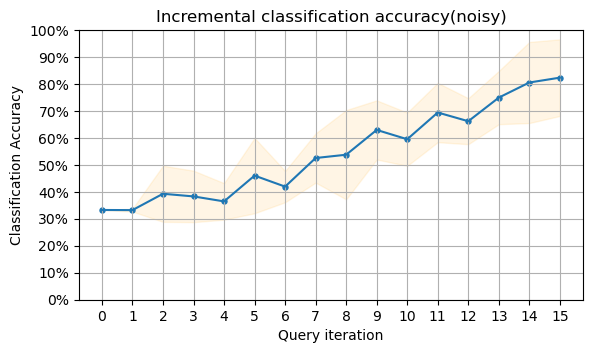

In [118]:
performance = pd.read_csv('performance_300_noisy_snr=-5.csv', header=None)
means = performance.mean()
stds = performance.std()
plt.style.use('default')
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(6.5, 3.5))
ax.plot(means)
ax.fill_between(range(len(means)), means-stds, means+stds, alpha=0.1, color='orange')
ax.scatter(range(len(means)), means, s=13)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=16, integer=True, min_n_ticks=16))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.grid(True)
#ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.set_title('Incremental classification accuracy(noisy)')
plt.show()
#save the plot
fig.savefig('AL_300_snr=-5.png')

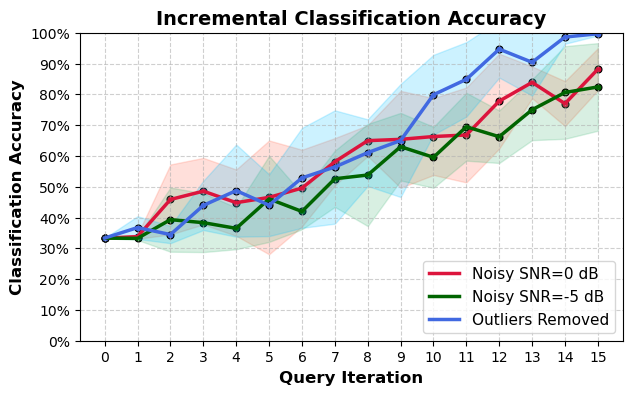

In [117]:
# Load both datasets
performance_noisy = pd.read_csv('performance_300_noisy.csv', header=None)
performance_clean = pd.read_csv('performance_300_clean.csv', header=None)
performance_noisy_snr5 = pd.read_csv('performance_300_noisy_snr=-5.csv', header=None)

# Compute means and standard deviations
means_noisy = performance_noisy.mean()
stds_noisy = performance_noisy.std()

means_clean = performance_clean.mean()
stds_clean = performance_clean.std()

means_noisy_snr5 = performance_noisy_snr5.mean()
stds_noisy_snr5 = performance_noisy_snr5.std()

plt.style.use('default')  

# Create the figure
fig, ax = plt.subplots(figsize=(7, 4))  

# Plot Noisy Data
ax.plot(means_noisy, label='Noisy SNR=0 dB', color='crimson', linewidth=2.5)
ax.fill_between(range(len(means_noisy)), means_noisy - stds_noisy, means_noisy + stds_noisy, alpha=0.2, color='tomato')
ax.scatter(range(len(means_noisy)), means_noisy, s=25, color='crimson', edgecolor='black', linewidth=0.8)

# Plot Noisy Data SNR=-5
ax.plot(means_noisy_snr5, label='Noisy SNR=-5 dB', color='darkgreen', linewidth=2.5)
ax.fill_between(range(len(means_noisy_snr5)), means_noisy_snr5 - stds_noisy_snr5, means_noisy_snr5 + stds_noisy_snr5, alpha=0.2, color='mediumseagreen')
ax.scatter(range(len(means_noisy_snr5)), means_noisy_snr5, s=25, color='darkgreen', edgecolor='black', linewidth=0.8)


# Plot Clean Data
ax.plot(means_clean, label='Outliers Removed', color='royalblue', linewidth=2.5)
ax.fill_between(range(len(means_clean)), means_clean - stds_clean, means_clean + stds_clean, alpha=0.2, color='deepskyblue')
ax.scatter(range(len(means_clean)), means_clean, s=25, color='royalblue', edgecolor='black', linewidth=0.8)

# Formatting the graph
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=16, integer=True, min_n_ticks=16))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.grid(True, linestyle='--', alpha=0.6)

# Labels and title
ax.set_xlabel('Query Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('Classification Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Incremental Classification Accuracy', fontsize=14, fontweight='bold')

# Add legend with better visibility
ax.legend(frameon=True, fontsize=11, loc='lower right')

# Show and save the plot
plt.show()
fig.savefig('AL_comparison.png', dpi=300)
